In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os
import matplotlib.ticker as ticker
from adjustText import adjust_text
import copy
import statistics
import pandas as pd

In [2]:
def open_file():
    path='C:\\Users\\zyx\\Desktop\\data\\spectrum\\1arcsec'  #设置存储路径
    files= os.listdir(path) #得到文件夹下的所有文件名称
    data=[]  # 建立空列表储存数据
    data_i=0 # 记录是第几个文件
    for file in files:  #按照顺序在 files 里面进行每一个文件的 数据名称 循环读取
        position = path+"\\"+file   # 打开第一个文件
        data.append([])
        with open(position, 'r') as f:
            line_num=0
            for line in f:
                if line_num>0:
                    data[data_i].append(line.strip().split())
                line_num+=1
        data_i+=1
    return data  

In [3]:
def data_to_xy(data):   # 输入某一个文件的数据，转换成xy
    data_x=[]
    data_y=[]
    for i in range(len(data)):
        data_x.append(float(data[i][0]))
        data_y.append(float(data[i][1]))
    return data_x,data_y

In [4]:
def paint(x,y):    # 把光谱画出来
    plt.plot(x,y)
    plt.xlabel("frequency (GHz)")
    plt.ylabel("flux (Jy/beam)")
    #plt.autoscale(enable=True, axis='y', tight=True)
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.show()

In [5]:
def hebin(list_x,list_y):    # 把列表每三个数据合成一个
    list_x_new=[]
    list_y_new=[]
    for i in range(int(len(list_x)/3)):
        x0=list_x[3*i]
        x1=list_x[3*i+1]
        x2=list_x[3*i+2]
        y0=list_y[3*i]
        y1=list_y[3*i+1]
        y2=list_y[3*i+2]
        list_x_new.append((x0+x1+x2)/3)
        list_y_new.append((y0+y1+y2)/3)
    return list_x_new,list_y_new

In [6]:
def noise_sigma(raw_data,a):
    noise=raw_data[a:a+300]    #宽度为0.2Hz的噪声区间
    noise_x,noise_y=data_to_xy(noise)
    noise_x1,noise_y1=hebin(noise_x,noise_y)
    paint(noise_x1,noise_y1)
    return noise_y1

1914


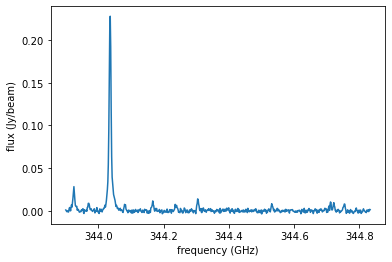

638
1914


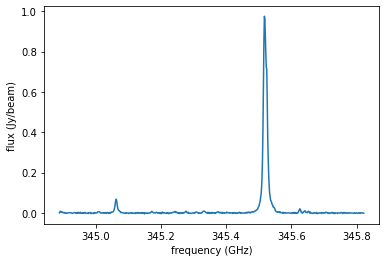

638
3834


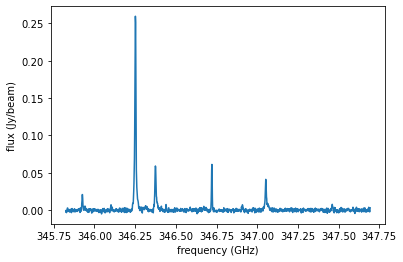

1278
3834


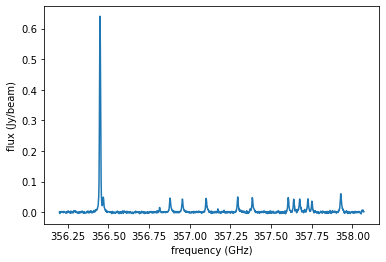

1278
3834


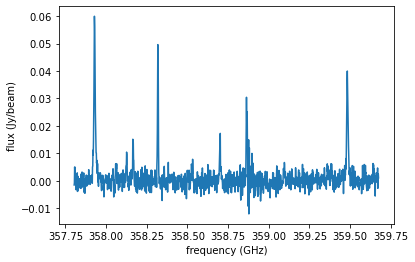

1278


In [7]:
data=open_file()
for i in range(len(data)):
    x,y=data_to_xy(data[i])
    print(len(x))
    x1,y1=hebin(x,y)
    paint(x1,y1)
    print(len(x1))

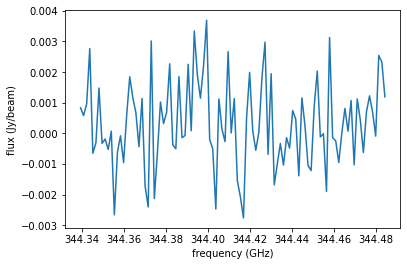

0.0013920901866183442


In [8]:
# 计算噪声的σ
noise_y=noise_sigma(data[0],900)
noise_level=np.std(noise_y)
print(noise_level)

In [9]:
# 去掉3σ外的数据（把噪声3σ下的删掉）
def remove_3sigma2(list1,list2):
    list3=[]
    a=max(list2)
    for i in range(len(list2)):
        if list2[i]<noise_level*3:
            list3.append(0)
        else:
            list3.append(list2[i])
     
    for i in range(len(list3)):     #把某一个突起值去掉
        if i<len(list3)-5:
            if list3[i]==0 and list3[i+2]==0 and list3[i+1]<a:   # 不能把峰值去掉了
                list3[i+1]=0
            elif list3[i]==0 and list3[i+3]==0 and list3[i+1]<a and list3[i+2]<a:
                list3[i+1]=0
                list3[i+2]=0
    return list3

In [10]:
# 去掉3σ外的数据（把噪声3σ下的删掉）（没有合并时）
def remove_3sigma3(list1,list2):
    list3=copy.deepcopy(list2)
    a=max(list2)
    n_a=list2.index(a)
# 从最大值开始往左边找
    for i in range(n_a-1,-1,-1):
        if list3[i]<noise_level*3 and list3[i-1]<noise_level*3:
            print("去除噪声（左边）")
            for j in range(i):
                list3[j]=0
            break
# 从最大值开始往右边找
    for i in range(n_a,len(list3)):
        if list3[i]<noise_level*3 and list3[i+1]<noise_level*3:
            print("去除噪声（右边）")
            for j in range(i,len(list3)):
                list3[j]=0
            break
    return list3

In [11]:
# 去掉噪声（小于0的话直接去掉）（没有合并时）
def remove_3sigma4(list1,list2):
    list3=copy.deepcopy(list2)
    a=max(list2)
    n_a=list2.index(a)
# 从最大值开始往左边找
    for i in range(n_a-1,-1,-1):
        if list3[i]<noise_level*1.5:
            print("去除噪声（左边）")
            for j in range(i+1):
                list3[j]=0
            break
# 从最大值开始往右边找
    for i in range(n_a,len(list3)):
        if list3[i]<noise_level*1.5:
            print("去除噪声（右边）")
            for j in range(i,len(list3)):
                list3[j]=0
            break
    return list3

In [12]:
# 归一化
def guiyihua(list5):
    a_max=max(list5)
    list6=[]
    for i in range(len(list5)):
        list6.append(list5[i]/a_max)
    return list6

In [13]:
def find_peak2(x,y):
    m=max(y)
    index_m=y.index(m)
    return m,index_m

In [14]:
# 放大谱线
def enlarge(x,y):
    m,index_m=find_peak2(x,y)
    data_x=x[index_m-80:index_m+80]
    data_y=y[index_m-80:index_m+80]
    return data_x,data_y

def enlarge2(peak_list,x,y):
    large_peak_list_x=[]    #放大后的谱线
    large_peak_list_y=[]
    data_x=np.array(x)
    data_x_real=data_x/(1-(239.5*10e3/(3.0*10e8)))   # 把频率的红移/蓝移移回来
    data_x_real=[float('{:.8f}'.format(j)) for j in data_x_real]

    for i in range(len(peak_list)):
        index_m=data_x_real.index(peak_list[i])
        #print(index_m)
        data_x=data_x_real[index_m-30:index_m+30]
        #print(data_x)
        data_y=y[index_m-30:index_m+30]
        #print(data_y)
        large_peak_list_x.append(data_x)
        large_peak_list_y.append(data_y)
        
        #paint(data_x,data_y)
    return large_peak_list_x,large_peak_list_y

In [15]:
def duiqi_v(list_x,list_y):
    delta_x=0.4262   # 频率步长
    x_start=-30 
    x_finish=30
    num=int((x_finish-x_start)/delta_x)+1  # 对齐之后数据长度
    y_flux=[]   # 对齐横坐标之后，只需要记录纵坐标。这是纵坐标。
    find_x=[]
    find_y=[]
    find_x=copy.deepcopy(list_x)
    find_y=copy.deepcopy(list_y)

    for i in range(num):
        a=x_start+i*delta_x
        b=x_start+(i+1)*delta_x

    # 找原横坐标对应区间(比如新x轴在【-26.4，-26】区间内的数据，就要找到原来x轴位于该区间的数据)
        if len(find_x)>=3:        # 原来x轴的数据还剩下3个以上
            data1_x=find_x[0]
            data2_x=find_x[1]
            data3_x=find_x[2]
            #print(data1_x)
            if data1_x>=a and data1_x<=b and data2_x>=b:
                y_flux.append(find_y[0])
                find_x.remove(data1_x)   # 把已经找到的数据删掉
                find_y.remove(find_y[0])
                #print("进入了第一种情况")
                continue
            elif data1_x>b:
                y_flux.append(0)
#                 print("有0")
#                 print(n)
#                 print(data1_x,data2_x,data3_x)
#                 print(a,b)
                continue
            elif data1_x>=a and data2_x<=b and data3_x>b:
                y_flux.append((find_y[0]+find_y[1])/2)
                find_x.remove(data1_x)
                find_x.remove(data2_x)
                find_y.remove(find_y[0])
                find_y.remove(find_y[0])
                #print("进入了第三种情况")
                continue

        elif len(find_x)==2:         # 原来x轴的数据还剩下2个
            #print("还有2个数据！")
            data1_x=find_x[0]
            data2_x=find_x[1]
            if data1_x>=a and data1_x<=b and data2_x>=b:
                y_flux.append(find_y[0])
                find_x.remove(data1_x)   # 把已经找到的数据删掉
                find_y.remove(find_y[0])
                #print("进入了第一种情况")
                continue
            elif data1_x>b:
                y_flux.append(0)

                continue
            elif data1_x>=a and data2_x<=b:
                y_flux.append((find_y[0]+find_y[1])/2)
                find_x.remove(data1_x)
                find_x.remove(data2_x)
                find_y.remove(find_y[0])
                find_y.remove(find_y[0])
                #print("进入了第三种情况")
                continue

        elif len(find_x)==1:       # 原来x轴的数据还剩下1个
            #print("还有1个数据！")
            y_flux.append(find_y[0])
            find_x.remove(find_x[0])   # 把已经找到的数据删掉
            find_y.remove(find_y[0])
            continue

        elif len(find_x)==0:
            #print("没有数据了！")
            y_flux.append(0)
        

    #print(y_flux)
    #plt.plot(y_flux)
    return y_flux

141


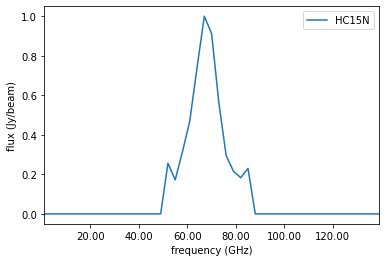

141


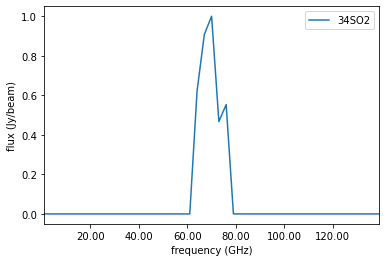

141


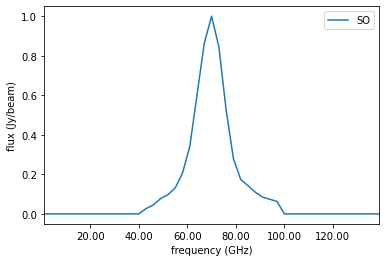

141


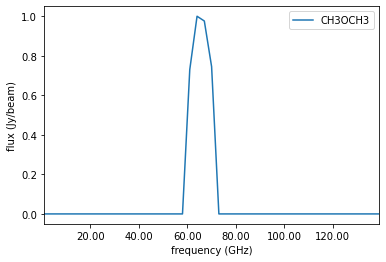

141


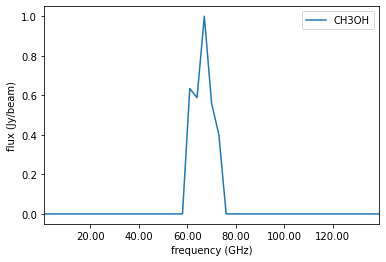

141


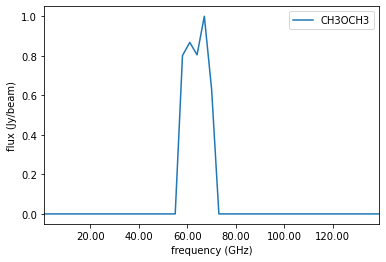

141


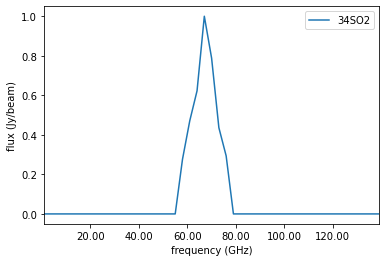

141


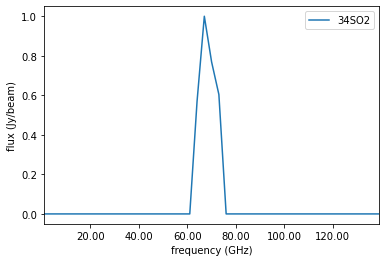

141


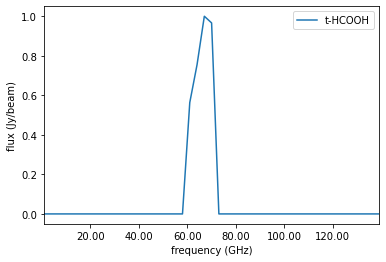

141


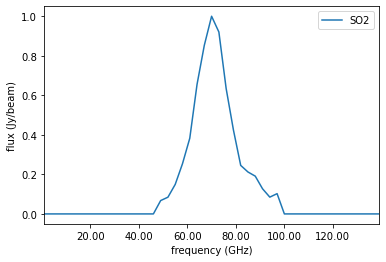

141


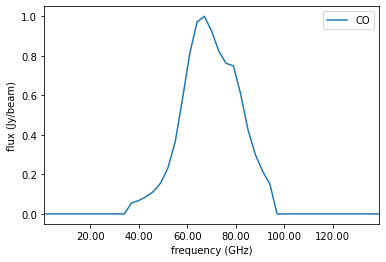

141


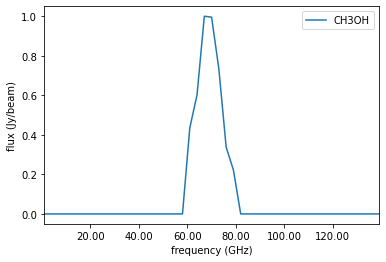

141


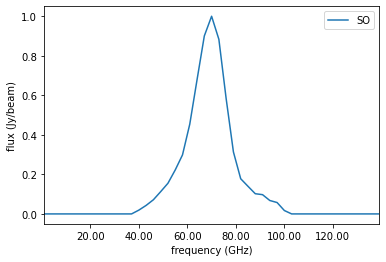

141


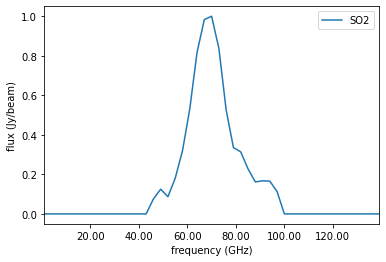

141


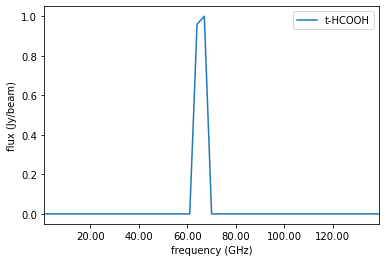

141


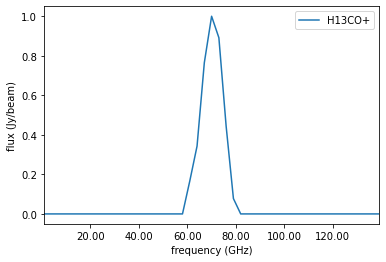

141


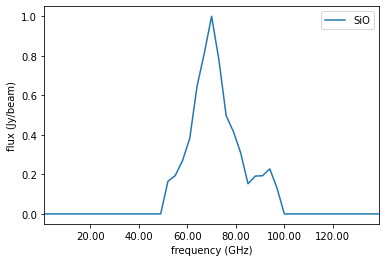

141


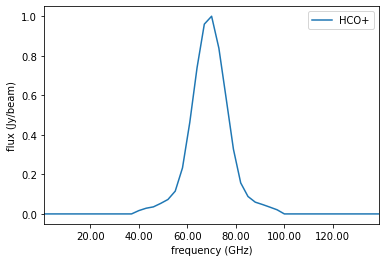

141


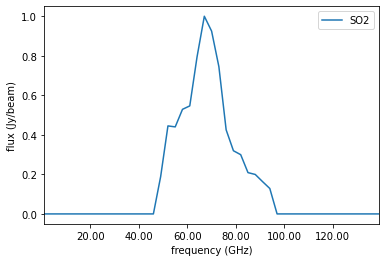

141


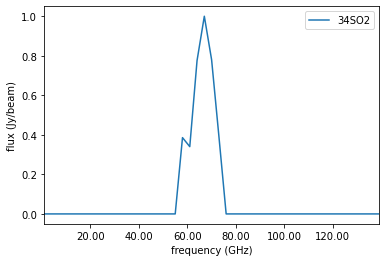

141


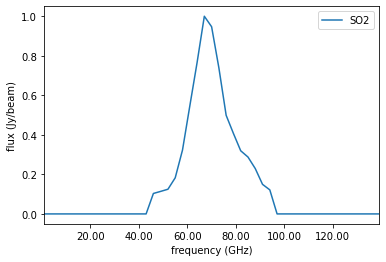

141


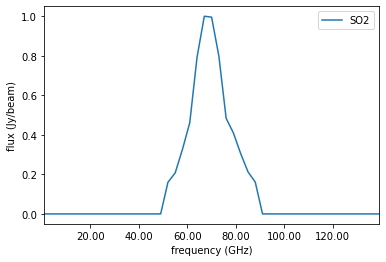

141


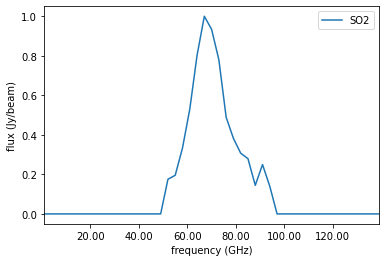

141


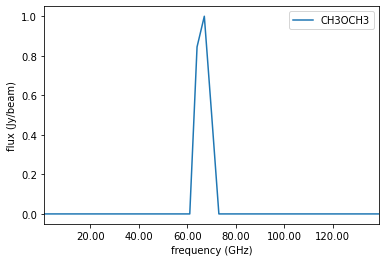

141


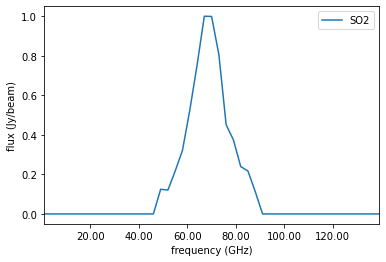

141


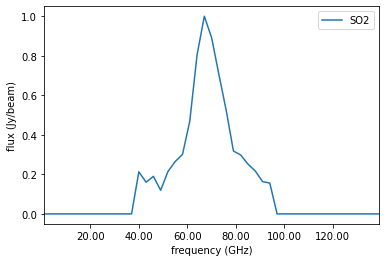

141


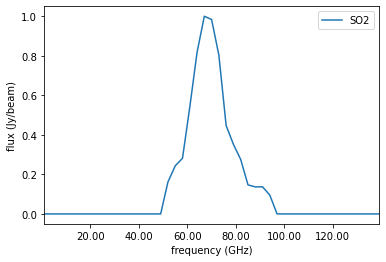

141


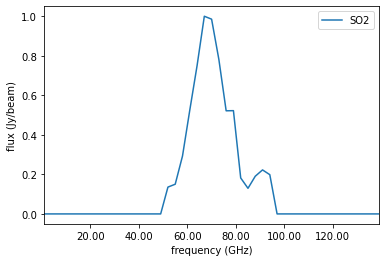

141


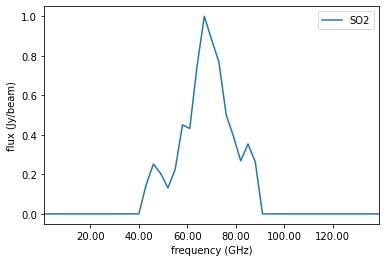

141


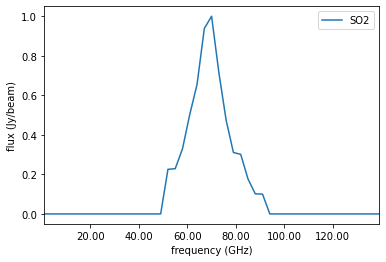

141


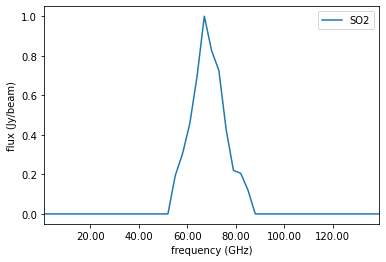

141


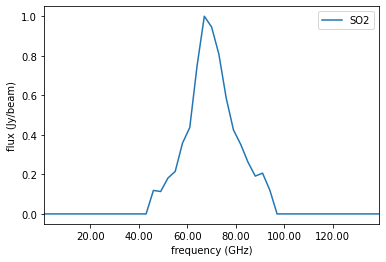

141


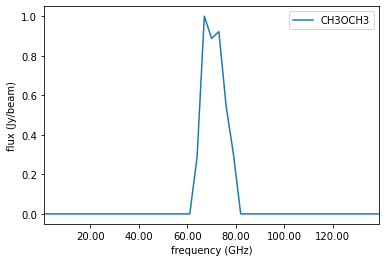

141


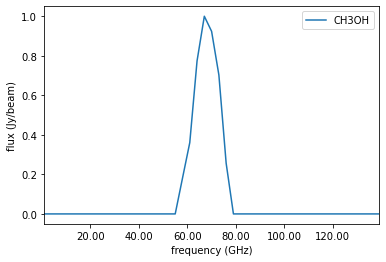

141


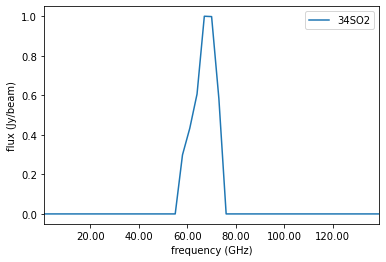

141


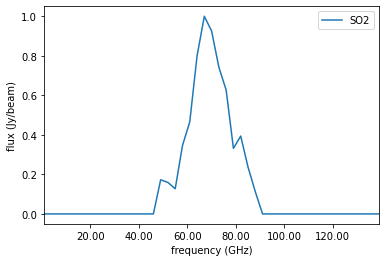

In [16]:
# 删掉识别不出的线和太密集的线
# 对齐速度
c=299792458

# name=['SO','CO','SO','HCO+','SO2']
# rest_fre=[344.31061200,345.79598990,346.52848100,356.73422300,358.21564000]

name_spw0=["HC15N","34SO2","SO","CH3OCH3","CH3OH","CH3OCH3","34SO2","34SO2","t-HCOOH"]
name_spw1=["SO2","CO"]
name_spw2=["CH3OH","SO","SO2","t-HCOOH","H13CO+","SiO"]
name_spw3=["HCO+","SO2","34SO2","SO2","SO2","SO2","CH3OCH3","SO2","SO2","SO2","SO2","SO2","SO2","SO2","SO2"]
name_spw4=["CH3OCH3","CH3OH","34SO2","SO2"]
name=[name_spw0,name_spw1,name_spw2,name_spw3,name_spw4]

spw0_peak=[344.19997631,344.24591399,344.31042249,344.35733694,344.44188244,344.51030006,344.57969546,344.80596309,345.03076456]
rest_fre0=[344.2003199, 344.2453476, 344.310612, 344.3580659, 344.443433, 344.5153801, 344.581045, 344.8079157,345.030561]

spw1_peak=[345.33849123,345.79395884]
rest_fre1=[345.3385391,345.7959899]

spw2_peak=[346.20164832,346.52858732,346.65173964,346.71624814,346.99822725,347.33054255]
rest_fre2=[346.202719,346.528481,346.6521672, 346.718858,  346.998344,347.330631]

spw3_peak=[356.73359532,356.75998539,357.10011993,357.16462743,357.2403759,357.38649655,357.45784651,357.58099883,357.67043123,357.89132257,357.92504249,357.96120636,358.01300872,358.03939879,358.21484185]
rest_fre3=[356.734223, 356.7551893, 357.1021822, 357.16536, 357.24119, 357.38757, 357.4602017, 357.5814483, 357.67178, 357.892442, 357.92596, 357.96289, 358.01309, 358.03808,358.21564]

spw4_peak=[358.45089029,358.6043418,358.98845945,359.76988829]
rest_fre4=[358.4519426, 358.605799, 358.9879745,359.7706815]

peak=[spw0_peak,spw1_peak,spw2_peak,spw3_peak,spw4_peak]
rest_fre=[rest_fre0,rest_fre1,rest_fre2,rest_fre3,rest_fre4]


x=[]
y=[]
data_flux=[]
#plt.figure(figsize=(10,6))
for i in range(len(data)):   #len(data)
    data_x,data_y=data_to_xy(data[i])   # 一个spw文件的所有x,y数据
    #for n in range(len(name)):    # 循环每一个spw
    x_large,y_large=enlarge2(peak[i],data_x,data_y)      # 一个光谱文件中，把所有的谱线挑出来，放在一个列表里 x_large=[[x,x,x,x],[x,x,x,x,x]]

    for j in range(len(x_large)):    # 循环一个spw的每一个峰len(x_large)
        list_x=[]
        list_y=[]

        for k in range(len(x_large[j])):            # 把某一个峰的列表数据取出来 peak1=x_large[i]=[x,x,x,x,x,x]
            list_x.append((c*(x_large[j][k]-rest_fre[i][j])/rest_fre[i][j])/1000)
#             list_x.append((c*(x_large[k]-rest_fre[j])/rest_fre[j])/1000+239.5)   # 将频率转换为速度，并加上视向速度
            list_y.append(y_large[j][k])
        

        copied_list_x = copy.deepcopy(list_x)
        y_flux=duiqi_v(copied_list_x,list_y)
        this_x=list(range(0,len(y_flux)))
        print(len(y_flux))
        #print(len(this_x))
        list_x_new,y_flux_new=hebin(this_x,y_flux)   # 合并
        #print(len(y_flux_new))

        y_flux_out_3sigma=remove_3sigma2(list_x_new,y_flux_new)  # 去除噪声
        
        y_flux_out_3sigma_nol=guiyihua(y_flux_out_3sigma)  # 归一化
        
        #plt.plot(list_x_new,y_flux_new,label=name[i][j]) 
        #plt.plot(list_x_new,y_flux_new,this_x,y_flux,list_x_new,y_flux_out_3sigma,label=name[i][j]) # 原始数据vs合并且去噪声
        plt.plot(list_x_new,y_flux_out_3sigma_nol,label=name[i][j])  # 归一化后的
        #print(len(x_flux_out_3sigma))
        
#         # 补齐长度(非常临时的方法！)
#         if len(x_flux_out_3sigma)!=21:
#             y_flux_out_3sigma.append(0)
            
        data_flux.append(y_flux_out_3sigma_nol)
        
#         print("长度：",len(y_flux_out_3sigma))
#        plt.plot(list_x,y_flux,label=name[i][j])
        
        plt.xlim(list_x_new[0]-0.02,list_x_new[-1]+0.02)
        ax = plt.gca()  # 获取当前轴
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

        plt.xlabel("frequency (GHz)")
        plt.ylabel("flux (Jy/beam)")

        x.append(list_x)
        y.append(list_y)
        
        

        plt.legend()
        plt.show()

In [17]:
# 提取上能级温度
tem_data_usb=pd.read_excel(r'line_identification.xlsx',sheet_name=1,usecols=[0,2,7])
tem_data_lsb=pd.read_excel(r'line_identification.xlsx',sheet_name=2,usecols=[0,2,7])

# 遍历频率找到对应上能级温度
tem0=[]
for i in range(len(rest_fre0)):
    fre=rest_fre0[i]
    for j in range(len(tem_data_lsb)):
        if tem_data_lsb.values[j,1]==fre:
            tem0.append(tem_data_lsb.values[j,2])

tem1=[]
for i in range(len(rest_fre1)):
    fre=rest_fre1[i]
    for j in range(len(tem_data_lsb)):
        if tem_data_lsb.values[j,1]==fre:
            tem1.append(tem_data_lsb.values[j,2])

tem2=[]
for i in range(len(rest_fre2)):
    fre=rest_fre2[i]
    for j in range(len(tem_data_lsb)):
        if tem_data_lsb.values[j,1]==fre:
            tem2.append(tem_data_lsb.values[j,2])
            
tem3=[]
for i in range(len(rest_fre3)):
    fre=rest_fre3[i]
    for j in range(len(tem_data_usb)):
        if tem_data_usb.values[j,1]==fre:
            tem3.append(tem_data_usb.values[j,2])
            
tem4=[]
for i in range(len(rest_fre4)):
    fre=rest_fre4[i]
    for j in range(len(tem_data_usb)):
        if tem_data_usb.values[j,1]==fre:
            tem4.append(tem_data_usb.values[j,2])

tem=[tem0,tem1,tem2,tem3,tem4]
tem_all = np.concatenate(tem).tolist()
print(tem_all)

[24.7793, 71.9661, 70.9573, 150.6497, 434.6966, 56.2495, 151.0955, 105.0607, 126.4935, 76.4101, 16.5962, 98.5456, 62.1444, 151.5015, 127.818, 24.9808, 58.3478, 25.6816, 72.7122, 167.6567, 105.8234, 132.5369, 82.8004, 142.6542, 55.2022, 63.4714, 47.835, 41.402, 162.9316, 35.8865, 31.2935, 168.1381, 31.601, 27.0532, 101.6364, 196.9916]


In [18]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE,MDS, Isomap,LocallyLinearEmbedding,SpectralEmbedding
from sklearn.decomposition import PCA


In [19]:
#print(data_flux)
print(len(data_flux))


36


D:\conda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\conda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<class 'numpy.ndarray'>


<Figure size 720x720 with 0 Axes>

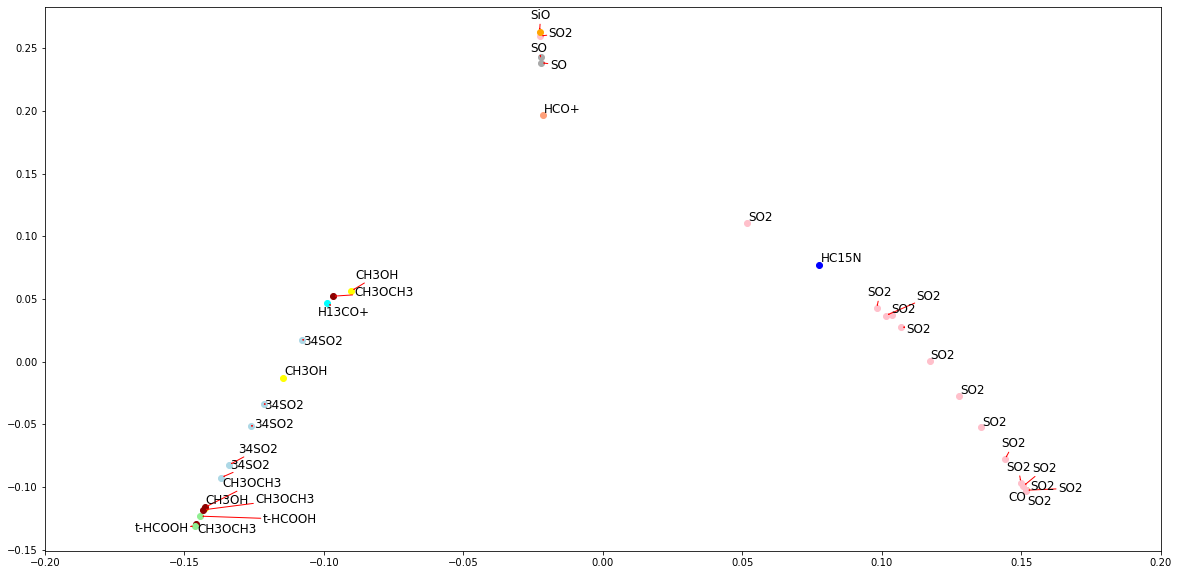

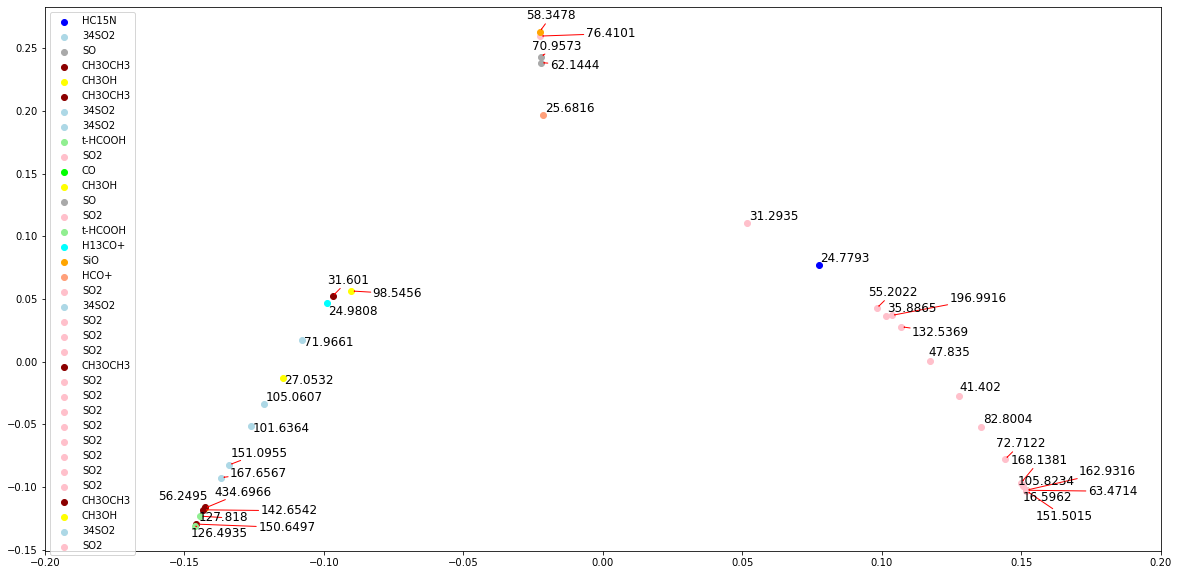

In [20]:

 
tsne=TSNE(random_state=42)
mds=MDS(n_components=2)
#iso=Isomap(n_components=2,n_neighbors=30)
#local=LocallyLinearEmbedding(n_components=2)
spec=SpectralEmbedding(n_components=2)
 
digits_tsne=tsne.fit_transform(data_flux)
digits_mds=mds.fit_transform(data_flux)
# digits_iso=iso.fit_transform(data_flux)
# digits_local=local.fit_transform(data_flux)
digits_spec=spec.fit_transform(data_flux)
# print(digits_tsne)
# colors=['#476A2A','#7851B8','#BD3430','#4A2D4E','#875525',
#         '#A83683','#4E655E','#853541','#3A3120','#535D8E']

color_map = {'33SO2':'#000000', '13CH3OH???':'#FF0000', 'CO':'#00FF00', 'HC15N':'#0000FF', 'CH3OH':'#FFFF00','H13CO+':'#00FFFF','SO+':'#FF00FF','SiO':'#FFA500', 'SO2':'#FFC0CB', 'HCO+':'#FFA07A', 'SO':'#A9A9A9', 'CH3OCH3':'#8B0000', '34SO2':'#ADD8E6', 't-HCOOH':'#90EE90', 'SO2_v2=1???':'#D8BFD8'}
 
plt.figure(figsize=(10,10))
# plt.xlim(digits_tsne[:,0].min(),digits_tsne[:,0].max()+1)
# plt.ylim(digits_tsne[:,1].min(),digits_tsne[:,1].max()+1)

new_name = np.concatenate(name).tolist()
# title=list(range(0,0+1*42,1))

# for i in range(len(digits_tsne)):
#     plt.scatter(digits_tsne[i, 0], digits_tsne[i, 1], color=color_map[new_name[i]], label=new_name[i])

# plt.legend()
# plt.xlabel('t-SNE feature 0')
# plt.ylabel('t-SNE feature 1')
# plt.show()

# # MDS
# plt.figure(figsize=(20,10))
# # plt.xlim(digits_mds[:,0].min(),digits_mds[:,0].max()+1)
# # plt.ylim(digits_mds[:,1].min(),digits_mds[:,1].max()+1)
# for i in range(len(digits_mds)):
# #     plt.text(digits_mds[i,0],digits_mds[i,1],str(new_name[i]),
# #              color=colors[i],
# #              fontdict={'weight':'bold','size':15})
#     plt.scatter(digits_mds[i, 0], digits_mds[i, 1], color=color_map[new_name[i]], label=new_name[i])
# new_texts = [plt.text(x_, y_, text, fontsize=12) for x_, y_, text in zip(digits_mds[:, 0], digits_mds[:, 1], tem_all)]
# adjust_text(new_texts,arrowprops=dict(arrowstyle='->',color='red',lw=1))
# # plt.ylim(-1,1)
# # plt.xlim(-1,1)
# plt.legend()
# plt.show()

# SpectralEmbedding
plt.figure(figsize=(20,10))
# plt.xlim(digits_spec[:,0].min(),digits_spec[:,0].max()+1)
# plt.ylim(digits_spec[:,1].min(),digits_spec[:,1].max()+1)
plt.xlim(-0.2,0.2)
for i in range(len(digits_spec)):
#     plt.text(digits_spec[i,0],digits_spec[i,1],str(new_name[i]),
#              color=colors[i],
#              fontdict={'weight':'bold','size':15})
    plt.scatter(digits_spec[i, 0], digits_spec[i, 1], color=color_map[new_name[i]], label=new_name[i])
    
new_texts = [plt.text(x_, y_, text, fontsize=12) for x_, y_, text in zip(digits_spec[:, 0], digits_spec[:, 1], new_name)]
adjust_text(new_texts,arrowprops=dict(arrowstyle='->',color='red',lw=1))

# SpectralEmbedding1
plt.figure(figsize=(20,10))
# plt.xlim(digits_spec[:,0].min(),digits_spec[:,0].max()+1)
# plt.ylim(digits_spec[:,1].min(),digits_spec[:,1].max()+1)
plt.xlim(-0.2,0.2)
for i in range(len(digits_spec)):
#     plt.text(digits_spec[i,0],digits_spec[i,1],str(new_name[i]),
#              color=colors[i],
#              fontdict={'weight':'bold','size':15})
    plt.scatter(digits_spec[i, 0], digits_spec[i, 1], color=color_map[new_name[i]], label=new_name[i])
    
new_texts = [plt.text(x_, y_, text, fontsize=12) for x_, y_, text in zip(digits_spec[:, 0], digits_spec[:, 1], tem_all)]
adjust_text(new_texts,arrowprops=dict(arrowstyle='->',color='red',lw=1))

print(type(digits_spec))
plt.legend()
plt.show()

(36, 47)


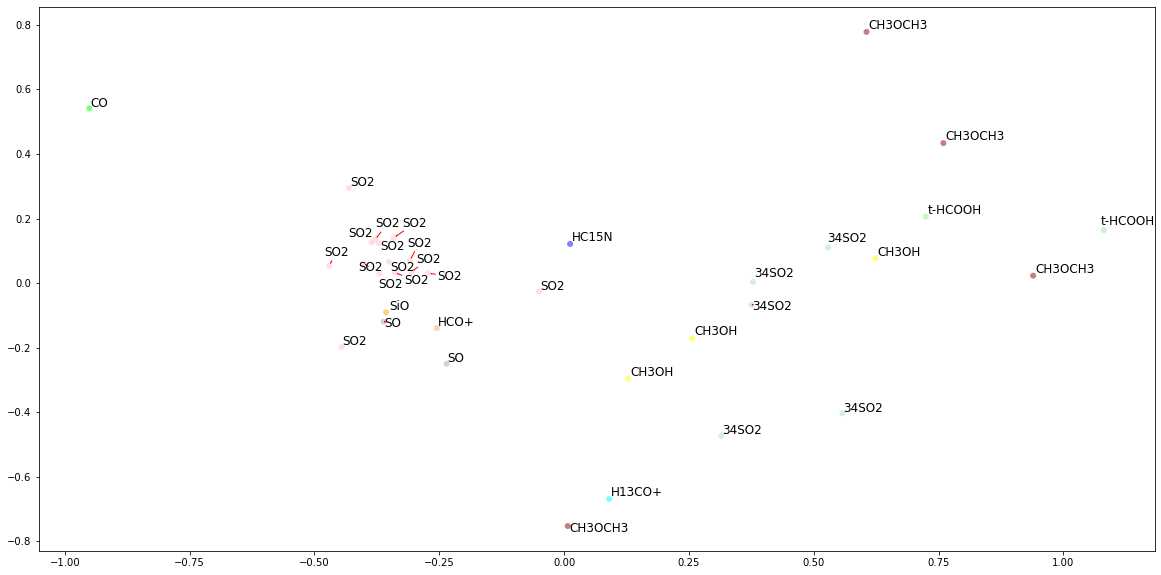

主成分（特征向量）：
 [[ 2.08166817e-17 -0.00000000e+00 -0.00000000e+00 -2.77555756e-17
   6.93889390e-18 -0.00000000e+00  1.69406589e-21 -1.32348898e-23
  -4.13590306e-25  1.61558713e-27  5.04870979e-29 -1.97215226e-31
  -6.43670810e-03 -1.80752175e-02 -2.72535960e-02 -5.36852710e-02
  -8.50373031e-02 -1.54629600e-01 -2.05655977e-01 -2.07141995e-01
  -1.52691974e-01 -2.48485048e-03  2.00520325e-02 -2.80791069e-01
  -5.11372679e-01 -4.43708754e-01 -3.73728201e-01 -2.87266714e-01
  -2.15376809e-01 -1.63807509e-01 -1.20634623e-01 -9.09827475e-02
  -2.16980058e-02 -7.54762586e-04 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [ 5.55111512e-17 -1.11022302e-16  2.77555756e-17  2.77555756e-17
  -1.38777878e-17 -4.33680869e-19 -5.42101086e-20  0.00000000e+00
  -2.64697796e-23  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.92066960

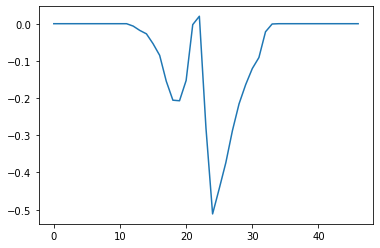

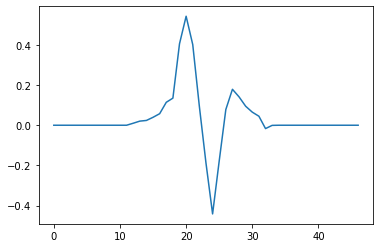

In [21]:
# PCA
data_flux=np.array(data_flux)
print(data_flux.shape)
model = PCA(2)  # project from 64 to 2 dimensions
model.fit(data_flux)
digits_pca = model.transform(data_flux)

plt.figure(figsize=(20,10))
for i in range(len(digits_pca)):
    plt.scatter(digits_pca[i, 0],digits_pca[i, 1], edgecolor='none', alpha=0.5,color=color_map[new_name[i]], label=new_name[i])
    
new_texts = [plt.text(x_, y_, text, fontsize=12) for x_, y_, text in zip(digits_pca[:, 0], digits_pca[:, 1], new_name)]
adjust_text(new_texts,arrowprops=dict(arrowstyle='->',color='red',lw=1))
#plt.legend()
plt.show()

# 5. 输出PCA的主成分和解释方差
print("主成分（特征向量）：\n", model.components_)
print("解释方差（每个主成分的贡献）：", model.explained_variance_ratio_)
com=model.components_
plt.plot(com[0])
plt.show()
plt.plot(com[1])
plt.show()

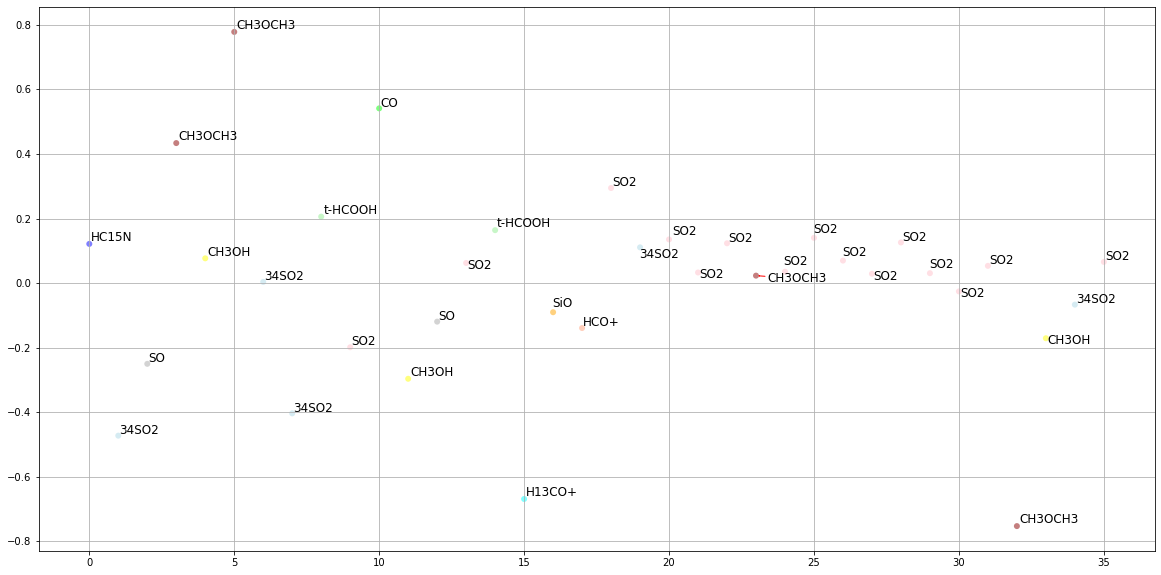

In [22]:
ax_pca=np.arange(0,36,1)
# x方向
plt.figure(figsize=(20,10))
for i in range(len(digits_pca)):
    plt.scatter(ax_pca[i],digits_pca[i, 1], edgecolor='none', alpha=0.5, color=color_map[new_name[i]],label=new_name[i])

new_texts = [plt.text(x_, y_, text, fontsize=12) for x_, y_, text in zip(ax_pca, digits_pca[:, 1], new_name)]
adjust_text(new_texts,arrowprops=dict(arrowstyle='->',color='red',lw=1))
plt.grid()
plt.show()

In [23]:
# 求平均谱线
def mean_spec(list7):
    mean=[]
    for i in range(len(list7[0])):  # 数据长度
        mean_data=0
        for j in range(len(list7)):   # 有几组数据
            mean_data+=list7[j][i]
        mean.append(mean_data/len(list7))
    return mean

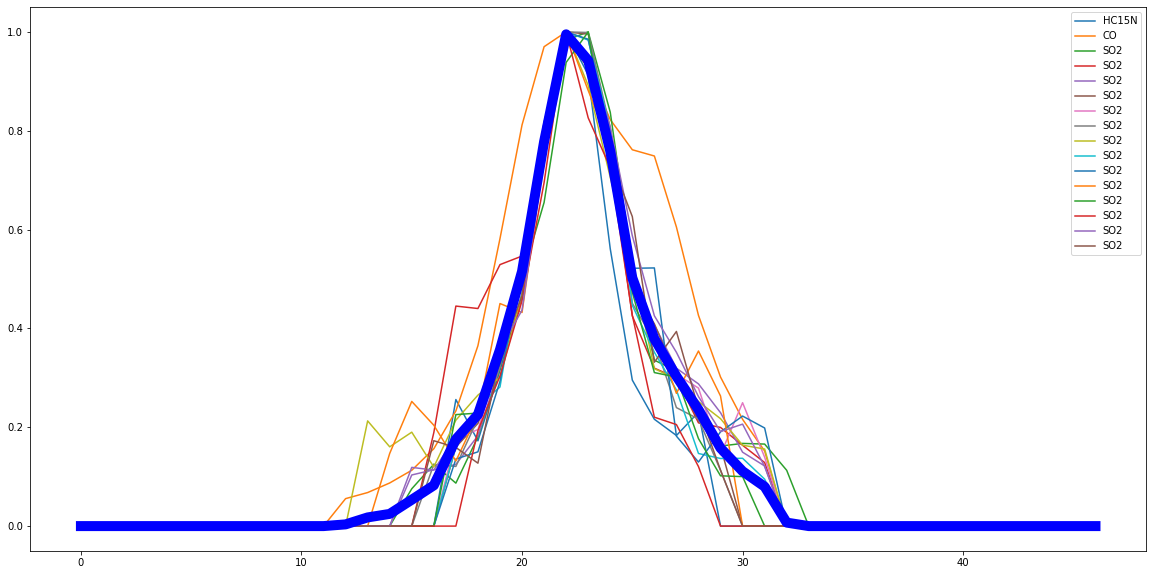

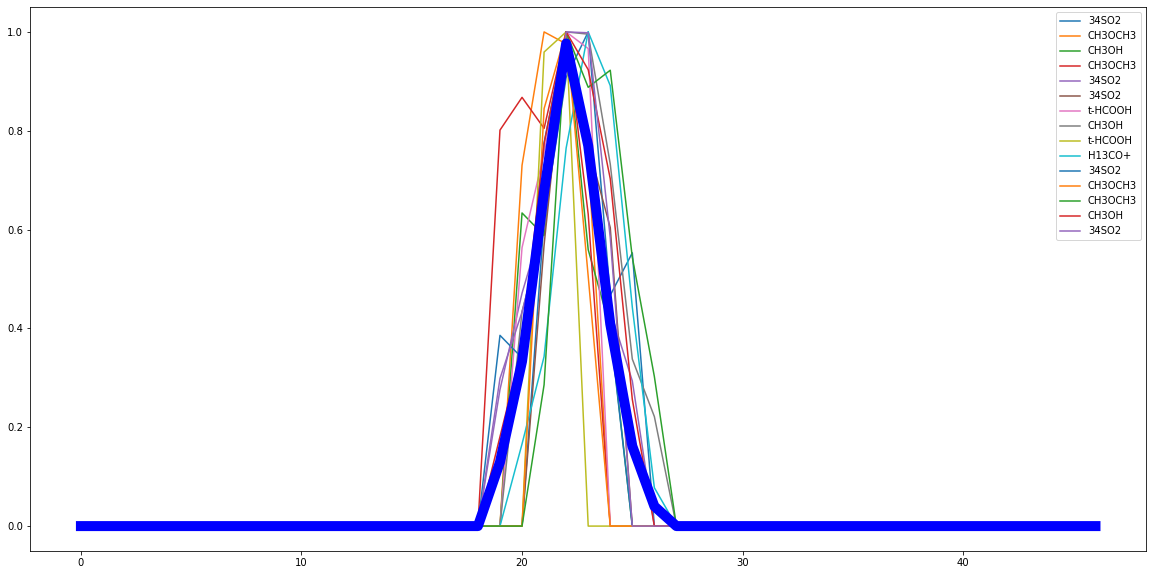

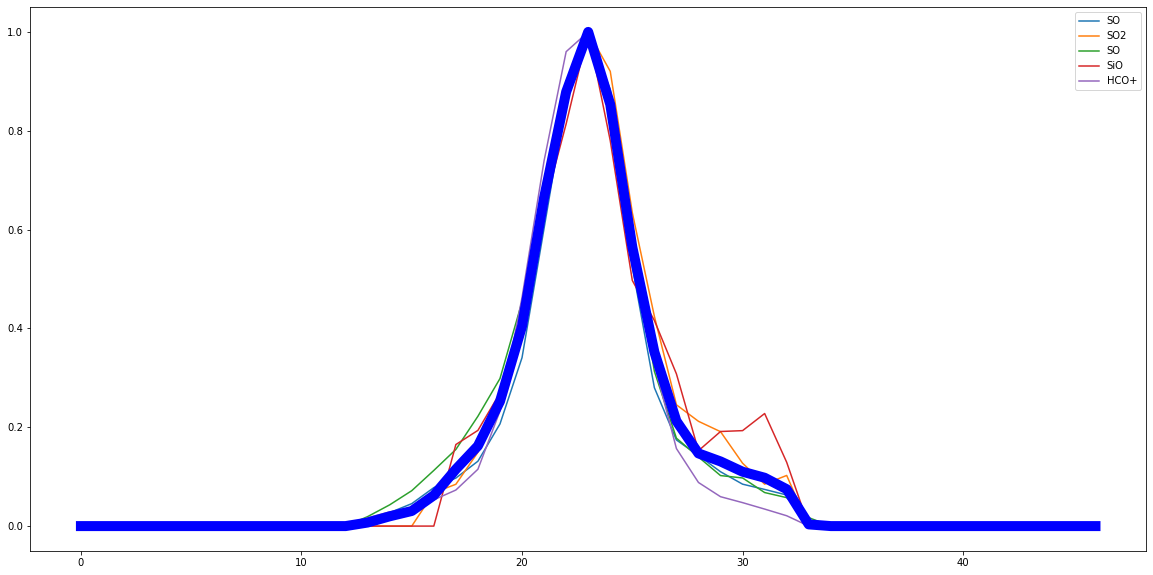

In [24]:
#print(digits_spec)
cate1=[]
name1=[]
mean1=[]
cate2=[]
name2=[]
mean2=[]
cate3=[]
name3=[]
mean3=[]
for i in range(len(digits_spec)):
    if digits_spec[i,0]>0 and digits_spec[i,1]<0.15:
        cate1.append(data_flux[i])
        name1.append(new_name[i])
        
    elif digits_spec[i,0]<0 and digits_spec[i,1]<0.15:
        cate2.append(data_flux[i])
        name2.append(new_name[i])
    elif digits_spec[i,0]<0.0 and digits_spec[i,1]>0.15:
        cate3.append(data_flux[i])
        name3.append(new_name[i])

# 求平均光谱
mean1=mean_spec(cate1)
mean2=mean_spec(cate2)
mean3=mean_spec(cate3)

# 画图
plt.figure(figsize=(20,10))
for i in range(len(cate1)):  
    plt.plot(cate1[i],label=name1[i])

plt.plot(mean1,linewidth=10,color="b")
#plt.ylim(-0.05,0.1)
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
for i in range(len(cate2)):
    plt.plot(cate2[i],label=name2[i])

plt.plot(mean2,linewidth=10,color="b")
#plt.xlim(25,150)
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
for i in range(len(cate3)):
    plt.plot(cate3[i],label=name3[i])

plt.plot(mean3,linewidth=10,color="b")
#plt.xlim(25,150)
plt.legend()
plt.show()

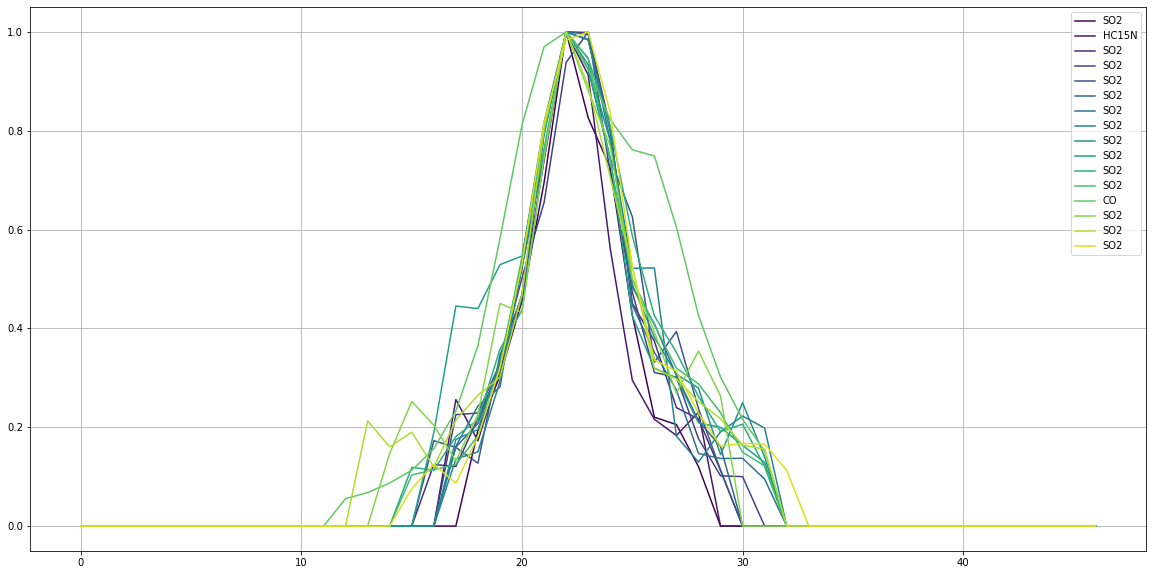

In [25]:
# 把SO2的x增大顺序画出来
sort_x_so2=[]    # 按顺序排列的x值
cate1_x_so2=[]  # x值
digits_so2_x=[]  # 谱线流量
name_so2_x=[]    # 记录谱线的名字

for i in range(len(digits_spec)):
    if digits_spec[i,0]>0 and digits_spec[i,1]<0.15:
        digits_so2_x.append(digits_spec[i,0])
        cate1_x_so2.append(data_flux[i])
        name_so2_x.append(new_name[i])
        
linewidth_x=[]
x_so2=zip(digits_so2_x,cate1_x_so2,name_so2_x)
sorted_x_so2 = sorted(x_so2,key=lambda x:x[0])
result = zip(*sorted_x_so2)
sorted_so2_x, sorted_so2_flux,sorted_so2_name = [list(x) for x in result]

cmap = plt.cm.viridis
plt.figure(figsize=(20,10))

for i in range(len(sorted_so2_flux)):   # 算一下线宽（最底部）
    #print(sorted_so2_x[i])
    a=0
    b=0
    for j in range(len(sorted_so2_flux[i])-1):
        if sorted_so2_flux[i][j]==0 and sorted_so2_flux[i][j+1]>0:
            a=j
        if sorted_so2_flux[i][j]==0 and sorted_so2_flux[i][j-1]>0:
            b=j
    
    #print("线宽：",b-a)
    linewidth_x.append(b-a)
    
    color = cmap(i / len(sorted_so2_flux))
    plt.plot(sorted_so2_flux[i],color=color,label=sorted_so2_name[i])
    #plt.title("x value:{}".format(sorted_so2_x[i]))
    #plt.title("name:{}".format(sorted_so2_name[i]))
    #plt.savefig('./picture/sorted_x-{}.png'.format(i + 1))


plt.legend(loc="upper right")
plt.grid()
plt.show()

#print(linewidth_x)

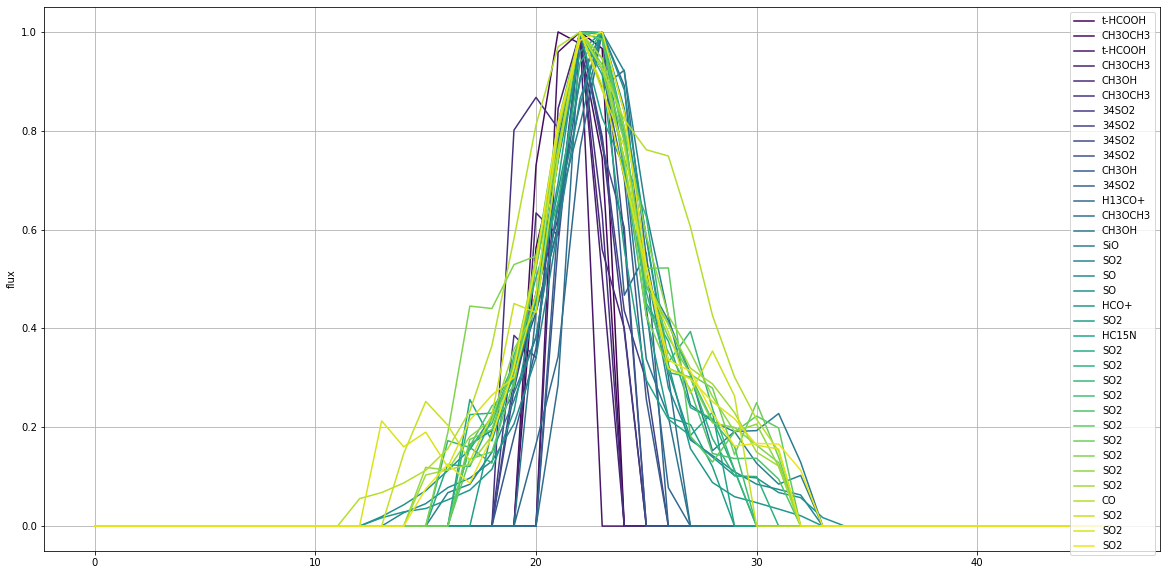

In [26]:
# 把所有谱线按的x增大顺序画出来
sort_x=[]    # 按x顺序排列的下面三个列表的组合
cate1_x=[]  # 谱线流量
digits_x=[]  # 分类结果中该谱线的x值
name_x=[]    # 记录谱线的名字

for i in range(len(digits_spec)):
    digits_x.append(digits_spec[i,0])
    cate1_x.append(data_flux[i])
    name_x.append(new_name[i])
        
linewidth_x_all=[]
x_=zip(digits_x,cate1_x,name_x)
sort_x = sorted(x_,key=lambda x:x[0])
result = zip(*sort_x)
sorted_x, sorted_flux,sorted_name = [list(x) for x in result]

cmap = plt.cm.viridis
plt.figure(figsize=(20,10))

for i in range(len(sorted_flux)):   # 算一下线宽（最底部）
    #print(sorted_so2_x[i])
    a=0
    b=0
    for j in range(len(sorted_flux[i])-1):
        if sorted_flux[i][j]==0 and sorted_flux[i][j+1]>0:
            a=j
        if sorted_flux[i][j]==0 and sorted_flux[i][j-1]>0:
            b=j
    
    #print("线宽：",b-a)
    linewidth_x_all.append(b-a)
    
    color = cmap(i / len(sorted_flux))
    plt.plot(sorted_flux[i],color=color,label=sorted_name[i])
    #plt.title("x value:{}".format(sorted_so2_x[i]))
    #plt.title("name:{}".format(sorted_so2_name[i]))
    #plt.savefig('./picture/sorted_x-{}.png'.format(i + 1))


plt.legend(loc="upper right")
plt.ylabel("flux")
plt.grid()
plt.show()

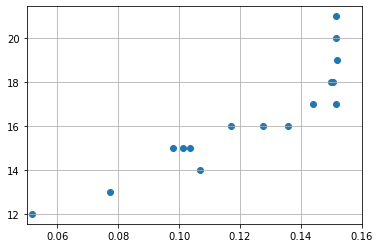

In [27]:
# 画出x值和线宽的散点图
sorted_so2_x = np.array(sorted_so2_x)
linewidth_x = np.array(linewidth_x)
plt.scatter(sorted_so2_x,linewidth_x)
plt.xlim(0.05,0.16)
plt.grid()
plt.show()

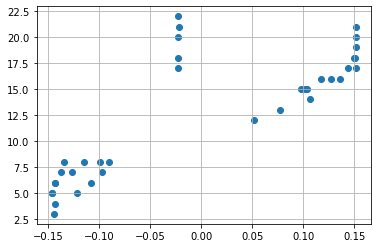

In [28]:
# 画出所有谱线x值和线宽的散点图
sorted_x = np.array(sorted_x)
linewidth_x_all = np.array(linewidth_x_all)
plt.scatter(sorted_x,linewidth_x_all)
#plt.xlim(0.05,0.16)
plt.grid()
plt.show()

In [29]:
# 把SO2的y增大顺序画出来
sort_y_so2=[]
cate1_y_so2=[]
digits_so2_y=[]

for i in range(len(digits_spec)):
    if digits_spec[i,0]>0 and digits_spec[i,1]<0.15:
        digits_so2_y.append(digits_spec[i,1])
        cate1_y_so2.append(data_flux[i])
        
linewidth_y=[]
y_so2=zip(digits_so2_y,cate1_y_so2)
sorted_y_so2 = sorted(y_so2,key=lambda x:x[0])
result = zip(*sorted_y_so2)
sorted_so2_y, sorted_so2_flux = [list(x) for x in result]

for i in range(len(sorted_so2_flux)):   # 算一下线宽（最底部）
    print(sorted_so2_y[i])
    a=0
    b=0
    for j in range(len(sorted_so2_flux[i])-1):
        if sorted_so2_flux[i][j]==0 and sorted_so2_flux[i][j+1]>0:
            a=j
        if sorted_so2_flux[i][j]==0 and sorted_so2_flux[i][j-1]>0:
            b=j
    linewidth_y.append(b-a)
    print("线宽：",b-a)
#     plt.plot(sorted_so2_flux[i])
#     plt.title("y value:{}".format(sorted_so2_y[i]))
#     plt.savefig('./picture/sorted_y-{}.png'.format(i + 1))
#     plt.show()
print(linewidth_y)

-0.10295652931425181
线宽： 19
-0.10250386678181798
线宽： 21
-0.10250386678181794
线宽： 20
-0.10250386678181786
线宽： 17
-0.09926937037413046
线宽： 18
-0.09667348809249963
线宽： 18
-0.07791596838945215
线宽： 17
-0.0522679913437954
线宽： 16
-0.0270401583472192
线宽： 16
0.0005789567123304899
线宽： 16
0.027958887762676618
线宽： 14
0.03684363076079418
线宽： 15
0.03695772879455899
线宽： 15
0.0426882326806361
线宽： 15
0.07710567738732602
线宽： 13
0.11054892432629239
线宽： 12
[19, 21, 20, 17, 18, 18, 17, 16, 16, 16, 14, 15, 15, 15, 13, 12]


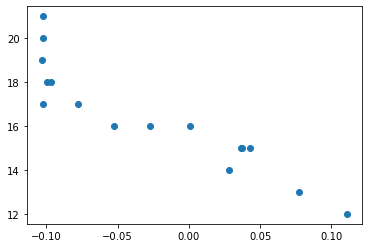

In [30]:
# 画出y值和线宽的散点图
plt.scatter(sorted_so2_y,linewidth_y)

plt.show()

In [31]:
# 计算半高全宽
def calculate_fwhm(x, y, n): # n是取多少高
    # 确保x和y为NumPy数组
    x = np.asarray(x)
    y = np.asarray(y)
    
    # 找到峰值位置
    peak_index = np.argmax(y)
    peak_value = y[peak_index]
    half_max = peak_value*n

    # 处理左侧交点
    i_left = peak_index - 1
    while i_left >= 0 and y[i_left] > half_max:
        i_left -= 1
    
    if i_left < 0:
        raise ValueError("未找到左侧半高交点，请检查数据。")
    if i_left + 1 >= len(y):
        raise ValueError("左侧交点超出范围。")
    
    # 线性插值计算左侧交点x坐标
    dx_left = x[i_left + 1] - x[i_left]
    dy_left = y[i_left + 1] - y[i_left]
    x_left = x[i_left] + (half_max - y[i_left]) * dx_left / dy_left

    # 处理右侧交点
    i_right = peak_index + 1
    while i_right < len(y) and y[i_right] >= half_max:
        i_right += 1
    
    if i_right >= len(y):
        raise ValueError("未找到右侧半高交点，请检查数据。")
    if i_right - 1 < peak_index:
        raise ValueError("右侧交点无效。")
    
    # 线性插值计算右侧交点x坐标
    dx_right = x[i_right] - x[i_right - 1]
    dy_right = y[i_right] - y[i_right - 1]
    x_right = x[i_right - 1] + (half_max - y[i_right - 1]) * dx_right / dy_right
    return x_right - x_left

In [32]:
# 底线宽
def linewidth(y):
    a=0
    b=0
    for i in range(len(y)-1):
        if y[i]==0 and y[i+1]>0:
            a=i
        if y[i]==0 and y[i-1]>0:
            b=i
    
    #print("线宽：",b-a)
    return (b-a)

In [33]:
def simpson_integral(x, y):
    # 检查数据均匀间隔
    h = x[1] - x[0]
    for i in range(1, len(x)):
        if not np.isclose(x[i] - x[i-1], h):
            raise ValueError("数据点必须均匀间隔！")
    
    # 检查偶数个区间（数据点数为奇数）
    n = len(x) - 1  # 区间数
    if n % 2 != 0:
        raise ValueError("区间数需为偶数（数据点数需为奇数）")
    
    # 辛普森公式计算
    integral = y[0] + y[-1]
    for i in range(1, n):
        if i % 2 == 0:
            integral += 2 * y[i]
        else:
            integral += 4 * y[i]
    integral *= h / 3
    return integral

In [34]:
# 面积
def area(x,y):
    a=np.trapz(y, x)
    return a

In [35]:
# 面积比值
def a_ratio(x,y,n):
# 找到对应高度的横坐标
    # 确保x和y为NumPy数组
    x = np.asarray(x)
    y = np.asarray(y)
    
    # 找到峰值位置
    peak_index = np.argmax(y)
    peak_value = y[peak_index]
    half_max = peak_value*n

    # 处理左侧交点
    i_left = peak_index - 1
    while i_left >= 0 and y[i_left] > half_max:
        i_left -= 1
    
    if i_left < 0:
        raise ValueError("未找到左侧半高交点，请检查数据。")
    if i_left + 1 >= len(y):
        raise ValueError("左侧交点超出范围。")
    
    # 线性插值计算左侧交点x坐标
    dx_left = x[i_left + 1] - x[i_left]
    dy_left = y[i_left + 1] - y[i_left]
    x_left = x[i_left] + (half_max - y[i_left]) * dx_left / dy_left

    # 处理右侧交点
    i_right = peak_index + 1
    while i_right < len(y) and y[i_right] >= half_max:
        i_right += 1
    
    if i_right >= len(y):
        raise ValueError("未找到右侧半高交点，请检查数据。")
    if i_right - 1 < peak_index:
        raise ValueError("右侧交点无效。")
    
    # 线性插值计算右侧交点x坐标
    dx_right = x[i_right] - x[i_right - 1]
    dy_right = y[i_right] - y[i_right - 1]
    x_right = x[i_right - 1] + (half_max - y[i_right - 1]) * dx_right / dy_right
    
# 计算面积
    x_left_int=int(x_left)
    x_right_int=int(x_right)
    left=np.arange(0,x_left_int+1)
    right=np.arange(x_right_int+1,x[-1]+1)
    area_left=np.trapz( y[0:x_left_int+1],left)
    area_right=np.trapz(y[x_right_int+1:x[-1]+1],right)
    area_middle=(x_right-x_left)*half_max
    return area_left+area_right

In [36]:
def tr(a):
    a+=1
    return a
aaa=1
print(tr(aaa))
print(aaa)

2
1


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


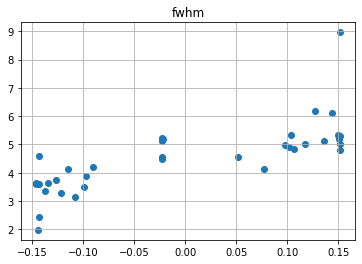

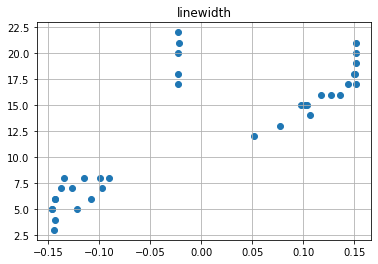

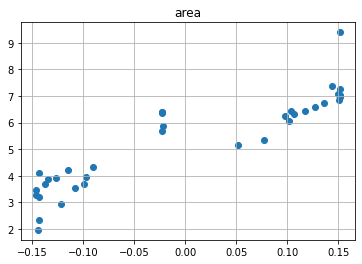

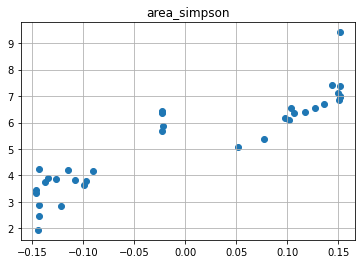

In [37]:
fwhm_full=[]
linewidth_full=[]
area_full=[]
area_full2=[]
flux_x = np.arange(0, len(sorted_flux[1]),1)
print(flux_x)
for i in range(len(sorted_x)):
    fwhm=calculate_fwhm(flux_x,sorted_flux[i],0.5)
    fwhm_full.append(fwhm)
    linewid=linewidth(sorted_flux[i])
    linewidth_full.append(linewid)
    area_full.append(area(flux_x,sorted_flux[i]))
    area2 = simpson_integral(flux_x,sorted_flux[i])
    area_full2.append(area2)

# 画出所有谱线x值和不同属性的散点图
plt.scatter(sorted_x,fwhm_full)
#plt.xlim(0.05,0.16)
plt.title("fwhm")
plt.grid()
plt.show()

plt.scatter(sorted_x,linewidth_full)
#plt.xlim(0.05,0.16)
plt.title("linewidth")
plt.grid()
plt.show()

plt.scatter(sorted_x,area_full)
#plt.xlim(0.05,0.16)
plt.title("area")
plt.grid()
plt.show()

plt.scatter(sorted_x,area_full2)
#plt.xlim(0.05,0.16)
plt.title("area_simpson")
plt.grid()
plt.show()

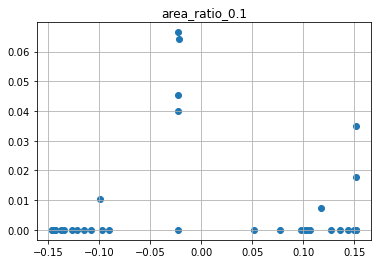

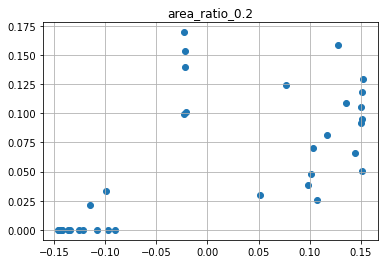

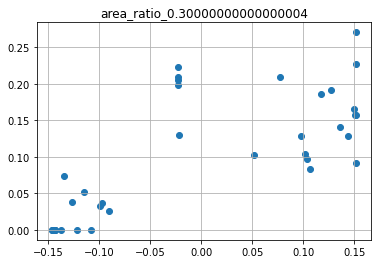

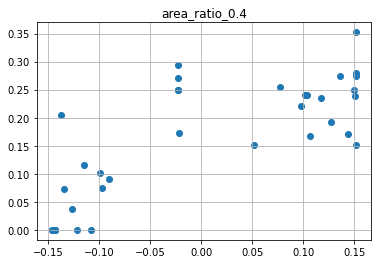

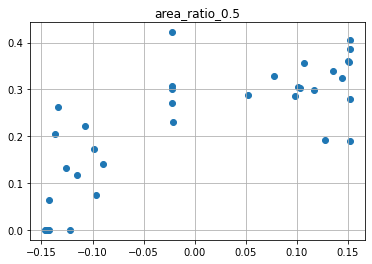

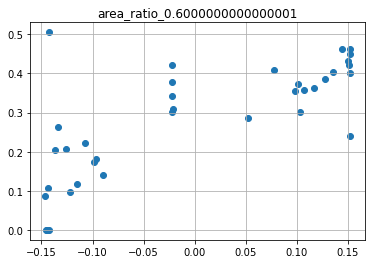

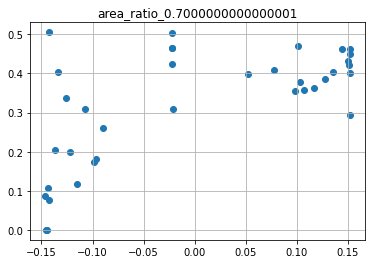

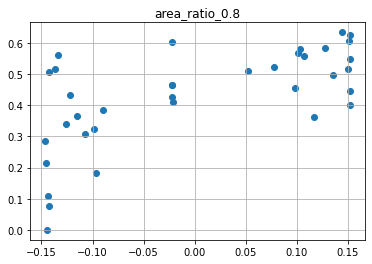

In [38]:

flux_x = np.arange(0, len(sorted_flux[1]),1)
for n in range(1,9):
    area_full=[]
    area_ratio=[]
    for i in range(len(sorted_x)):
        area_full.append(area(flux_x,sorted_flux[i]))
        area_ratio.append(a_ratio(flux_x,sorted_flux[i],n*0.1)/area(flux_x,sorted_flux[i]))
    plt.scatter(sorted_x,area_ratio)
    #plt.xlim(0.05,0.16)
    plt.title("area_ratio_{}".format(n*0.1))
    plt.grid()
    plt.show()

In [39]:
# 均方根
def ruggedness_rms(y):
    dy = np.diff(y)
    return np.sqrt(np.mean(dy**2))

In [40]:
# 信息熵
def ruggedness_entropy(y):
    y_normalized = y / np.sum(y)
    entropy = -np.sum(y_normalized * np.log2(y_normalized + 1e-10))  # 避免log(0)
    return entropy

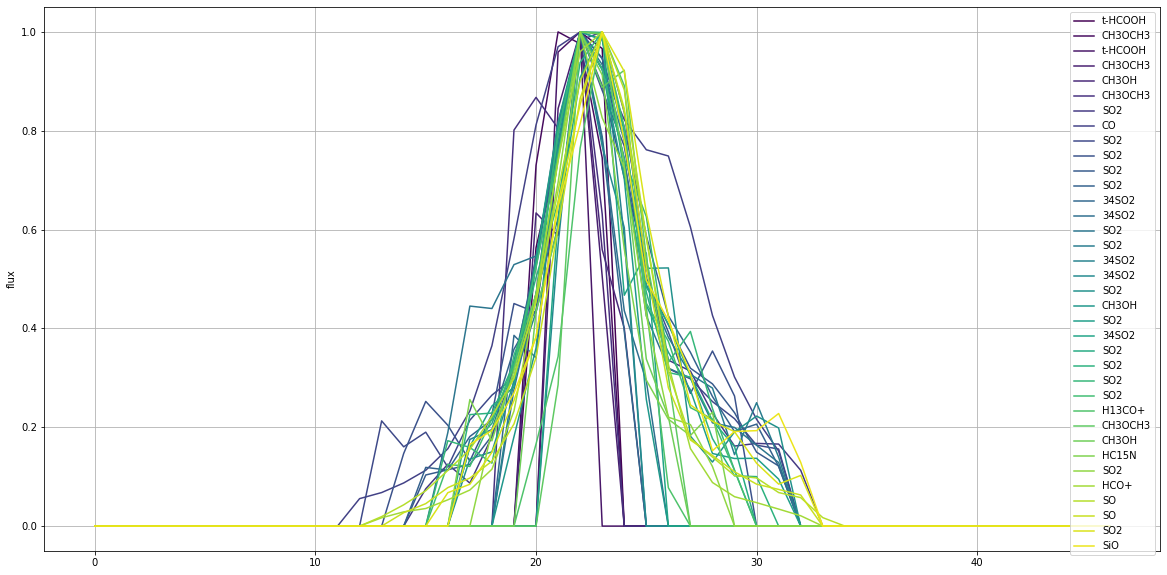

In [41]:
# 把所有谱线按y的增大顺序画出来
sort_y=[]    # 按顺序排列的y值
cate1_y=[]  # x值
digits_y=[]  # 谱线流量
name_y=[]    # 记录谱线的名字

for i in range(len(digits_spec)):
    digits_y.append(digits_spec[i,1])
    cate1_y.append(data_flux[i])
    name_y.append(new_name[i])
        
y_=zip(digits_y,cate1_y,name_y)
sort_y = sorted(y_,key=lambda x:x[0])
result = zip(*sort_y)
sorted_y, sorted_flux_y,sorted_name_y = [list(x) for x in result]

cmap = plt.cm.viridis
plt.figure(figsize=(20,10))

rms_y=[]
entropy_y=[]
linewidth_y=[]
fwhm_y=[]
area_y=[]

for i in range(len(sorted_flux_y)):
    color = cmap(i / len(sorted_flux_y))
    plt.plot(sorted_flux_y[i],color=color,label=sorted_name_y[i])
    rms_y.append(ruggedness_rms(sorted_flux_y[i]))
    entropy_y.append(ruggedness_entropy(sorted_flux_y[i]))
    linewidth_y.append(linewidth(sorted_flux_y[i]))
    fwhm_y.append(calculate_fwhm(flux_x,sorted_flux_y[i],0.5))
    area_y.append(area(flux_x,sorted_flux_y[i]))

plt.legend(loc="upper right")
plt.ylabel("flux")
plt.grid()
plt.show()

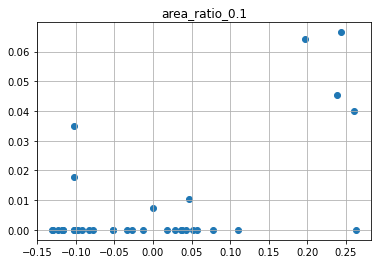

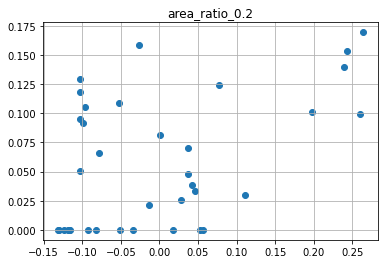

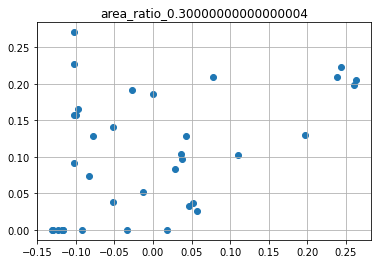

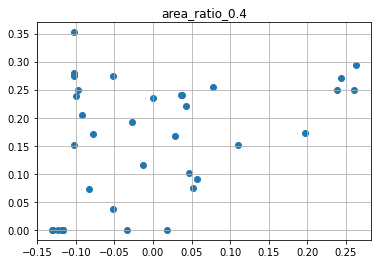

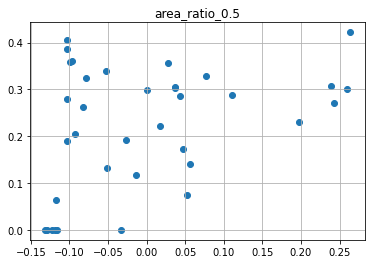

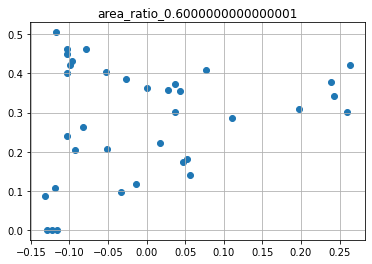

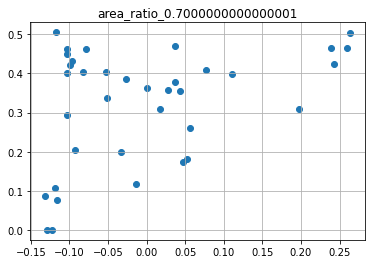

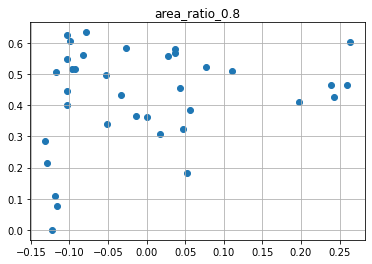

In [42]:
flux_x = np.arange(0, len(sorted_flux_y[1]),1)
for n in range(1,9):
    area_full_y=[]
    area_ratio_y=[]
    for i in range(len(sorted_y)):
        area_full_y.append(area(flux_x,sorted_flux_y[i]))
        area_ratio_y.append(a_ratio(flux_x,sorted_flux_y[i],n*0.1)/area(flux_x,sorted_flux_y[i]))
    plt.scatter(sorted_y,area_ratio_y)
    #plt.xlim(0.05,0.16)
    plt.title("area_ratio_{}".format(n*0.1))
    plt.grid()
    plt.show()

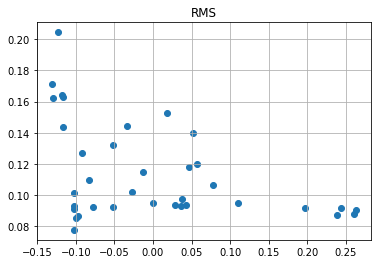

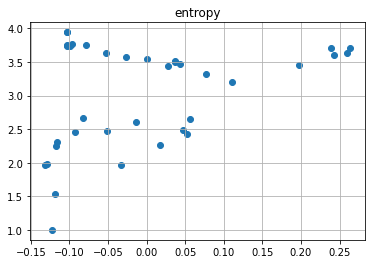

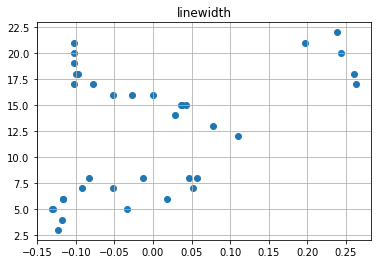

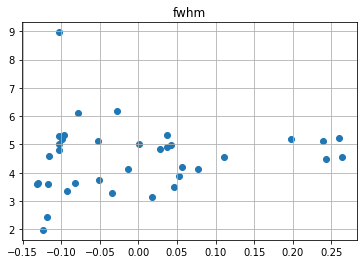

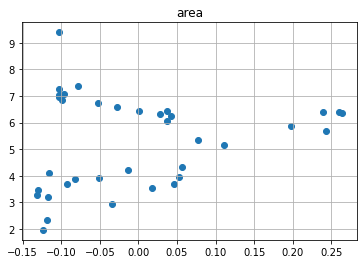

In [43]:
# 画出所有谱线y值和不同属性的散点图
plt.scatter(sorted_y,rms_y)
#plt.xlim(0.05,0.16)
plt.title("RMS")
plt.grid()
plt.show()

plt.scatter(sorted_y,entropy_y)
#plt.xlim(0.05,0.16)
plt.title("entropy")
plt.grid()
plt.show()

plt.scatter(sorted_y,linewidth_y)
#plt.xlim(0.05,0.16)
plt.title("linewidth")
plt.grid()
plt.show()

plt.scatter(sorted_y,fwhm_y)
#plt.xlim(0.05,0.16)
plt.title("fwhm")
plt.grid()
plt.show()

plt.scatter(sorted_y,area_y)
#plt.xlim(0.05,0.16)
plt.title("area")
plt.grid()
plt.show()

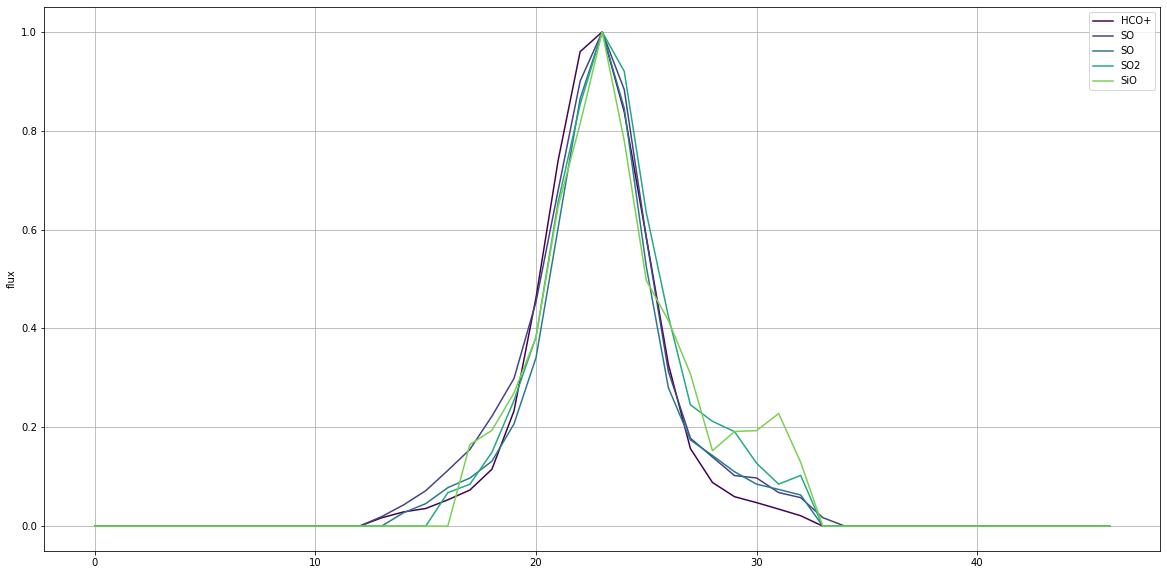

[0.19718835966940468, 0.23868247544660212, 0.24321204828855933, 0.25984216598361326, 0.26316346799936385]


In [44]:
# 把下半部分谱线按y的增大顺序画出来
sort_y_down=[]    # 按顺序排列的x值
cate1_y_down=[]  # x值
digits_y_down=[]  # 谱线流量
name_y_down=[]    # 记录谱线的名字

for i in range(len(digits_spec)):
    if digits_spec[i,1]>0.15 :
        digits_y_down.append(digits_spec[i,1])
        cate1_y_down.append(data_flux[i])
        name_y_down.append(new_name[i])
        
y_down_=zip(digits_y_down,cate1_y_down,name_y_down)
sort_y_down = sorted(y_down_,key=lambda x:x[0])
result = zip(*sort_y_down)
sorted_y_down, sorted_flux_y_down,sorted_name_y_down = [list(x) for x in result]

cmap = plt.cm.viridis
plt.figure(figsize=(20,10))


for i in range(len(sorted_flux_y_down)):
    color = cmap(i / len(sorted_flux_y_down))
    plt.plot(sorted_flux_y_down[i],color=color,label=sorted_name_y_down[i])


plt.legend(loc="upper right")
plt.ylabel("flux")
plt.grid()
plt.show()
print(sorted_y_down)